In [1]:
import numpy as np
from sklearn.decomposition import PCA
from torchvision import datasets, transforms, models
from latentmi import lmi, ksg
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import io
from PIL import Image

import torch.nn as nn
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
class MobileNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetClassifier, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet.classifier[1] = nn.Linear(self.mobilenet.last_channel, num_classes)

    def forward(self, x):
        return self.mobilenet(x)

def train_model(model, dataloader, epochs=5, jpeg_quality=100):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.numpy(), labels.numpy() 
            
            # Apply JPEG compression if quality is less than perfect
            if jpeg_quality < 100:
                inputs = apply_jpeg_compression(inputs, jpeg_quality)
            
            inputs, labels = torch.tensor(inputs).to(device).float(), torch.tensor(labels).to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs} (Quality {jpeg_quality}), Loss: {total_loss / len(dataloader):.4f}")

def apply_jpeg_compression(images, quality):
    """
    Applies JPEG compression to a batch of images.
    
    Args:
        images (np.array): Batch of images (N, C, H, W) normalized to approx [-1, 1]
        quality (int): JPEG quality level (1-100)
        
    Returns:
        np.array: The compressed and re-normalized images.
    """
    compressed_batch = np.zeros_like(images)
    
    # Define un-normalization parameters (matching the transform below)
    mean = np.array([0.5, 0.5, 0.5]).reshape(1, 3, 1, 1)
    std = np.array([0.5, 0.5, 0.5]).reshape(1, 3, 1, 1)
    
    # 1. Denormalize to [0, 1]
    imgs_unnorm = (images * std) + mean
    # Clip to ensure validity before scaling to uint8
    imgs_unnorm = np.clip(imgs_unnorm, 0, 1)
    # Scale to [0, 255] and cast
    imgs_uint8 = (imgs_unnorm * 255).astype(np.uint8)
    
    N = images.shape[0]
    
    for i in range(N):
        # Convert (C, H, W) -> (H, W, C) for PIL
        img_np = np.transpose(imgs_uint8[i], (1, 2, 0))
        pil_img = Image.fromarray(img_np)
        
        # In-memory JPEG compression
        buffer = io.BytesIO()
        pil_img.save(buffer, format="JPEG", quality=int(quality))
        buffer.seek(0) # Rewind
        
        # Read back
        reopened_img = Image.open(buffer)
        reopened_np = np.array(reopened_img)
        
        # Convert back to (C, H, W)
        reopened_np = np.transpose(reopened_np, (2, 0, 1))
        
        # 2. Re-normalize
        reopened_float = reopened_np.astype(np.float32) / 255.0
        reopened_norm = (reopened_float - 0.5) / 0.5
        
        compressed_batch[i] = reopened_norm

    return compressed_batch

def resample_one_v_all(true_labels, target_label):
    target_indices = []
    other_indices = []
    for i, label in enumerate(true_labels):
        if target_label == label:
            target_indices.append(i)
        else:
            other_indices.append(i)

    if len(other_indices) < len(target_indices):
        # Handle rare case where 'other' is smaller than 'target'
        selected_others = other_indices 
    else:
        selected_others = np.random.choice(other_indices, len(target_indices), replace=False)
        
    indices = np.concatenate([target_indices, selected_others])
    return indices.astype(int)

def estimate_mi(model, dataloader, jpeg_quality=100):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.numpy()
            
            # Apply JPEG
            if jpeg_quality < 100:
                inputs = apply_jpeg_compression(inputs, jpeg_quality)
                
            inputs = torch.tensor(inputs).to(device).float()
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            true_labels.append(labels.numpy())
            predicted_labels.append(preds)

    true_labels = np.concatenate(true_labels)
    predicted_labels = np.concatenate(predicted_labels)

    MIs = []
    N_samples = []
    label_names = []
    
    unique_labels = np.unique(true_labels)
    
    for label in unique_labels:
        N_samples.append(np.sum(true_labels == label))
        label_names.append(label)
        
        indices = resample_one_v_all(true_labels, label)
        binarized_true_labels = true_labels[indices] == label
        binarized_pred_labels = predicted_labels[indices] == label
        MIs.append(ksg.midd(binarized_true_labels, binarized_pred_labels))

    MIs.append(ksg.midd(true_labels, predicted_labels))
    N_samples.append(len(true_labels))
    label_names.append('all')

    return MIs, N_samples, label_names

In [3]:
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),
    transforms.Resize((240, 240)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# load dataset
Caltech101 = datasets.Caltech101(root='../data', download=True, transform=transform)

# get class labels
labels = Caltech101.y 
class_counts = Counter(labels)

# find top n largest classes
top_n = 5
top_n_classes = [cls for cls, _ in class_counts.most_common(top_n)]

indices = [i for i, label in enumerate(labels) if label in top_n_classes]
subset = torch.utils.data.Subset(Caltech101, indices)

N = len(subset)
print(f"{N} total samples")
train_set, val_set = torch.utils.data.random_split(subset, [N//2, N - N//2])

data_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)

d = {
    "Quality" : [],
    "MI" : [],
    "Class label" : [],
    "N instances of label" : []
}

MIs = []
# Qualities to process (100 is best, 1 is worst)
qualities = [100, 90, 75, 50, 25, 10, 5, 1]
print("JPEG Qualities to process:", qualities)

for quality in qualities:
    print(f"Training with JPEG Quality {quality}...")

    model = MobileNetClassifier(num_classes=101)
    model.to(device)
    
    # Train with compressed images
    train_model(model, data_loader, epochs=10, jpeg_quality=quality)

    # Estimate MI with compressed images
    mi, n_inst, lbls = estimate_mi(model, val_loader, jpeg_quality=quality)
    
    d['MI'] += mi
    d['Quality'] += [quality] * len(mi)
    d['Class label'] += lbls
    d["N instances of label"] += n_inst
    
df = pd.DataFrame(data=d)
print(df.head())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137M/137M [00:03<00:00, 41.4MB/s]


2707 total samples
JPEG Qualities to process: [100, 90, 75, 50, 25, 10, 5, 1]
Training with JPEG Quality 100...
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/gokulg/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


/orcd/home/002/gokulg/miniforge3/envs/scaling/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/orcd/home/002/gokulg/miniforge3/envs/scaling/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13.6M/13.6M [00:00<00:00, 151MB/s]


Epoch 1/10 (Quality 100), Loss: 3.0211
Epoch 2/10 (Quality 100), Loss: 0.4762
Epoch 3/10 (Quality 100), Loss: 0.0620
Epoch 4/10 (Quality 100), Loss: 0.0270
Epoch 5/10 (Quality 100), Loss: 0.0150
Epoch 6/10 (Quality 100), Loss: 0.0111
Epoch 7/10 (Quality 100), Loss: 0.0114
Epoch 8/10 (Quality 100), Loss: 0.0105
Epoch 9/10 (Quality 100), Loss: 0.0072
Epoch 10/10 (Quality 100), Loss: 0.0083
Training with JPEG Quality 90...
Epoch 1/10 (Quality 90), Loss: 2.8498
Epoch 2/10 (Quality 90), Loss: 0.4696
Epoch 3/10 (Quality 90), Loss: 0.0741
Epoch 4/10 (Quality 90), Loss: 0.0268
Epoch 5/10 (Quality 90), Loss: 0.0173
Epoch 6/10 (Quality 90), Loss: 0.0110
Epoch 7/10 (Quality 90), Loss: 0.0100
Epoch 8/10 (Quality 90), Loss: 0.0087
Epoch 9/10 (Quality 90), Loss: 0.0088
Epoch 10/10 (Quality 90), Loss: 0.0050
Training with JPEG Quality 75...
Epoch 1/10 (Quality 75), Loss: 3.1347
Epoch 2/10 (Quality 75), Loss: 0.4646
Epoch 3/10 (Quality 75), Loss: 0.0614
Epoch 4/10 (Quality 75), Loss: 0.0241
Epoch 5/10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


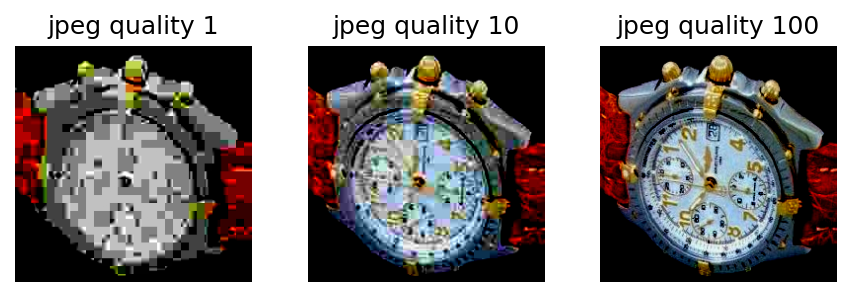

In [21]:
# visualize an image at different qualities
to_plot = [1, 10, 100]
fig, axes = plt.subplots(1, len(to_plot), figsize=(6, 2), dpi=150)  # adjust figsize as needed
for idx, f in enumerate(to_plot):
    downsampled = apply_jpeg_compression(train_set[100][0].unsqueeze(0).numpy(), f)
    axes[idx].axis('off')
    axes[idx].imshow(downsampled.transpose(0, 2, 3, 1)[0])
    axes[idx].set_title(f"jpeg quality {f}")

plt.tight_layout()
plt.show()

In [40]:

def apply_spectral_compression(images, keep_fraction):
    """
    Applies spectral gating (compression) by keeping only the lowest 
    frequencies in the Fourier domain.
    
    Args:
        images (torch.Tensor): Batch of images (N, C, H, W)
        keep_fraction (float): Fraction of frequencies to keep (0.0 to 1.0).
                               1.0 = Original Image
                               0.001 = Extreme blurring/destruction
    """
    if keep_fraction >= 1.0:
        return images

    # 1. Compute 2D FFT
    # rfft2 computes real-to-complex FFT (efficient for images)
    # Output shape: (N, C, H, W/2 + 1)
    freq_domain = torch.fft.rfft2(images)
    
    # 2. Create a mask
    # We want to keep the corners (low frequencies)
    h, w_complex = freq_domain.shape[-2:]
    
    # Calculate the cutoff index based on fraction
    # We treat keep_fraction as the radius ratio of frequencies to keep
    h_cutoff = max(1, int(h * keep_fraction))
    w_cutoff = max(1, int(w_complex * keep_fraction))

    mask = torch.zeros_like(freq_domain, device=images.device)
    
    # Keep low frequencies (top-left corner in RFFT format)
    # In standard FFT, low freqs are at corners. In RFFT, the u-axis (height) 
    # wraps around, v-axis (width) does not.
    
    # Mask for Height (handles wrapping)
    mask[:, :, :h_cutoff, :w_cutoff] = 1
    mask[:, :, -h_cutoff:, :w_cutoff] = 1 

    # 3. Apply mask and Inverse FFT
    filtered_freq = freq_domain * mask
    compressed_images = torch.fft.irfft2(filtered_freq, s=images.shape[-2:])
    
    return compressed_images

def train_model(model, dataloader, epochs=5, bandwidth=1.0):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply Spectral Compression
            if bandwidth < 1.0:
                inputs = apply_spectral_compression(inputs, bandwidth)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs} (Bandwidth {bandwidth}), Loss: {total_loss / len(dataloader):.4f}")

def estimate_mi(model, dataloader, bandwidth=1.0):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            
            if bandwidth < 1.0:
                inputs = apply_spectral_compression(inputs, bandwidth)
                
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            true_labels.append(labels.numpy())
            predicted_labels.append(preds)

    true_labels = np.concatenate(true_labels)
    predicted_labels = np.concatenate(predicted_labels)

    MIs = []
    N_samples = []
    label_names = []
    unique_labels = np.unique(true_labels)
    
    for label in unique_labels:
        N_samples.append(np.sum(true_labels == label))
        label_names.append(label)
        indices = resample_one_v_all(true_labels, label)
        binarized_true_labels = true_labels[indices] == label
        binarized_pred_labels = predicted_labels[indices] == label
        MIs.append(ksg.midd(binarized_true_labels, binarized_pred_labels))

    MIs.append(ksg.midd(true_labels, predicted_labels))
    N_samples.append(len(true_labels))
    label_names.append('all')

    return MIs, N_samples, label_names


transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),
    transforms.Resize((240, 240)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

Caltech101 = datasets.Caltech101(root='../data', download=True, transform=transform)
labels = Caltech101.y 
class_counts = Counter(labels)
top_n = 5
top_n_classes = [cls for cls, _ in class_counts.most_common(top_n)]
indices = [i for i, label in enumerate(labels) if label in top_n_classes]
subset = torch.utils.data.Subset(Caltech101, indices)

N = len(subset)
train_set, val_set = torch.utils.data.random_split(subset, [N//2, N - N//2])
data_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)

d = {
    "Bandwidth" : [],
    "MI" : [],
    "Class label" : [],
    "N instances of label" : []
}

MIs = []


bandwidths = np.logspace(-3, 0, 10)
print("Bandwidths to process:", bandwidths)

for bw in bandwidths:
    print(f"Training with Bandwidth {bw}...")

    model = MobileNetClassifier(num_classes=101)
    model.to(device)
    
    # Pass 'bandwidth' instead of downsample factor or quality
    train_model(model, data_loader, epochs=5, bandwidth=bw)

    mi, n_inst, lbls = estimate_mi(model, val_loader, bandwidth=bw)
    
    d['MI'] += mi
    d['Bandwidth'] += [bw] * len(mi)
    d['Class label'] += lbls
    d["N instances of label"] += n_inst
    
df = pd.DataFrame(data=d)
print(df.head())

Bandwidths to process: [0.001      0.00215443 0.00464159 0.01       0.02154435 0.04641589
 0.1        0.21544347 0.46415888 1.        ]
Training with Bandwidth 0.001...


/orcd/home/002/gokulg/miniforge3/envs/scaling/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/orcd/home/002/gokulg/miniforge3/envs/scaling/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 (Bandwidth 0.001), Loss: 3.4004
Epoch 2/5 (Bandwidth 0.001), Loss: 1.6035
Epoch 3/5 (Bandwidth 0.001), Loss: 1.0446
Epoch 4/5 (Bandwidth 0.001), Loss: 0.7686
Epoch 5/5 (Bandwidth 0.001), Loss: 0.6063
Training with Bandwidth 0.0021544346900318847...
Epoch 1/5 (Bandwidth 0.0021544346900318847), Loss: 3.3096
Epoch 2/5 (Bandwidth 0.0021544346900318847), Loss: 1.5258
Epoch 3/5 (Bandwidth 0.0021544346900318847), Loss: 1.0203
Epoch 4/5 (Bandwidth 0.0021544346900318847), Loss: 0.7711
Epoch 5/5 (Bandwidth 0.0021544346900318847), Loss: 0.6533
Training with Bandwidth 0.004641588833612777...
Epoch 1/5 (Bandwidth 0.004641588833612777), Loss: 3.4199
Epoch 2/5 (Bandwidth 0.004641588833612777), Loss: 1.6311
Epoch 3/5 (Bandwidth 0.004641588833612777), Loss: 1.0301
Epoch 4/5 (Bandwidth 0.004641588833612777), Loss: 0.7773
Epoch 5/5 (Bandwidth 0.004641588833612777), Loss: 0.6125
Training with Bandwidth 0.01...
Epoch 1/5 (Bandwidth 0.01), Loss: 3.4080
Epoch 2/5 (Bandwidth 0.01), Loss: 1.5102
Epoc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04355617..0.37625328].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0899949..1.3236264].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..1.0].


torch.Size([1, 3, 240, 240])
torch.Size([1, 3, 240, 240])
torch.Size([1, 3, 240, 240])


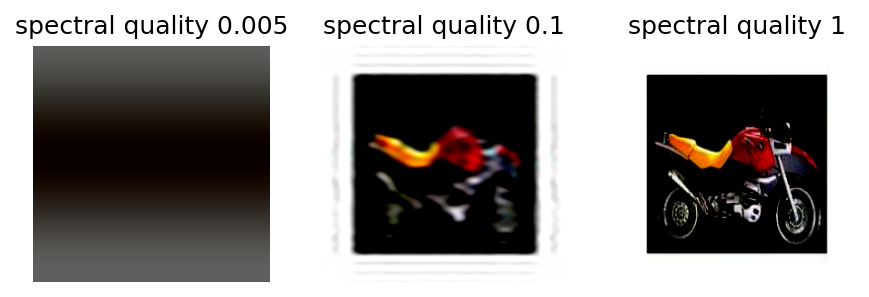

In [39]:
to_plot = [0.005, 0.1, 1]
fig, axes = plt.subplots(1, len(to_plot), figsize=(6, 2), dpi=150)  # adjust figsize as needed
for idx, f in enumerate(to_plot):
    downsampled = apply_spectral_compression(train_set[10][0].unsqueeze(0), f)
    print(downsampled.shape)
    axes[idx].axis('off')
    axes[idx].imshow(downsampled.squeeze(0).permute(1, 2, 0).cpu())
    axes[idx].set_title(f"spectral quality {f}")

plt.tight_layout()
plt.show()

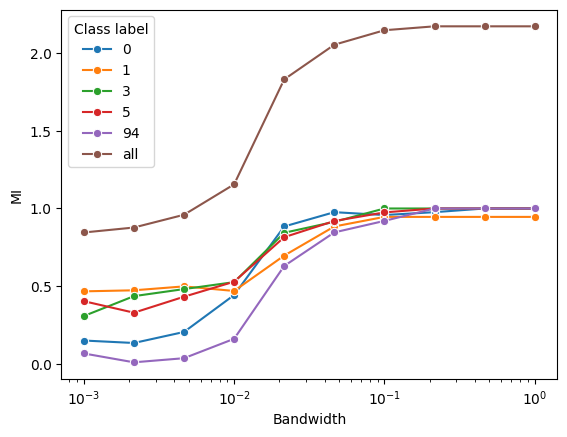

In [42]:
sns.lineplot(data=df, x="Bandwidth", y="MI", hue="Class label", marker="o")
plt.xscale('log')